# 3D analysis of X-ray Chandra data using gammapy

This notebook explores the possibility of performing a 3D (X,Y,E) analysis of X-ray data using the gammapy gamma-ray analysis tool.  
While at gamma-ray energies (due to moderate PSF), most sources can be represented by simple analitical functions (points, Gaussian, disks) this is less common in X-rays due to arcsec PSFs.  

Here we test the 3D analysis on a geometrically simple target (composite SNR IGR J14003-6326 aka SNR G310.6-1.6).  
In X-rays a nearly circular SNR shell, a PWN, and a pulsar are detected that we will model jointly.

The source is also sufficiently small (arcmin scale) to consider a flat exposure map and not having to handle CCD gaps.

Refs:
- [Discovery of a Highly Energetic Pulsar Associated with IGR J14003-6326 in the Young Uncataloged Galactic Supernova Remnant G310.6-1.6](https://ui.adsabs.harvard.edu/abs/2010ApJ...716..663R/abstract)
-[On the Expansion, Age, and Origin of the Puzzling Shell/Pulsar-wind Nebula G310.6-1.6](https://ui.adsabs.harvard.edu/abs/2019ApJ...887..233R/abstract)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
import astropy.units as u


import gammapy
gammapy.__version__

'0.19'

In [2]:

from gammapy.irf import EDispKernel,EDispKernelMap, EffectiveAreaTable2D
from gammapy.maps import WcsGeom, MapAxis, MapAxes, WcsNDMap, Map
gammapy.maps.MapAxes
from gammapy.modeling.models import PowerLawSpectralModel, GaussianSpectralModel
from gammapy.modeling.models.spatial import TemplateSpatialModel, GaussianSpatialModel, ShellSpatialModel
from gammapy.modeling.models import SkyModel
from gammapy.modeling import Fit
from gammapy.modeling.models import SpectralModel, Parameter

from gammapy.datasets.io import OGIPDatasetReader
from gammapy.datasets import MapDataset



In [3]:
# Implementing a quick absorption to avoid loading XSpec models for this example.
# Loading sherpa Xspec models is possible and currently being tested in gammapy

class WAbsSpectralModel(SpectralModel):
    tag = "WAbsSpectralModel"
    NH = Parameter("NH", "2.1e18 cm-2", min=0)
   
    @staticmethod
    def cross_section(energy):
        edges =  [0.030,  0.100, 0.284, 0.400, 0.532, 0.707, 0.867, 1.303, 1.840, 2.471, 3.210, 4.038, 7.111, 8.331, 10, 11]*u.keV   # 1 more edge
        axis = MapAxis.from_edges(edges, name="energy_true", interp="lin")
 
        c0 = np.array([17.3, 34.6, 78.1, 71.4, 95.5, 308.9, 120.6, 141.3, 202.7, 342.7, 352.2, 433.9, 629.0, 701.2])
        c1=np.array([608.1, 267.9, 18.8, 66.8, 145.8, -380.6, 169.3, 146.8, 104.7, 18.7, 18.7, -2.4, 30.9, 25.2])
        c2=np.array([-2150., -476.1, 4.3, -51.4, -61.1, 294.0, -47.7, -31.5, -17.0, 0.0, 0,0, 0.75, 0.0, 0.0])
  
        indices = axis.coord_to_idx(energy)
        indices = np.clip(indices, 0, 13)
        
        e_no_unit = energy.to_value("keV")
        cross_section = (c0[indices] + c1[indices]*e_no_unit  + c2[indices]*e_no_unit**2)
        cross_section *= e_no_unit**-3
        cross_section = cross_section*1e-24*u.cm**2
     
        return cross_section

    @staticmethod
    def evaluate(energy, NH):
        sigma = WAbsSpectralModel.cross_section(energy) 
        return np.exp(-sigma*NH)
    
    
def rebin_array(arr, rebinfactorx, rebinfactory, method='sum'):
    """
    Rebin array by an integer factor
    arr: ndarray
    rebinfactor: factor > 1
    method: ['sum','mean'] whether to sum or average when rebinning
    
    Returns
    ndarray
    """
        
    newx, newy =  arr.shape[0]/rebinfactorx, arr.shape[1]/rebinfactory
    shape = (int(newx), int(rebinfactorx),
             int(newy), int(rebinfactory) )
    
    if method == 'sum':
        print('Using SUM to rebin')
        return arr.reshape(shape).sum(-1).sum(1)
    if method == 'mean':
        print('Using MEAN to rebin')        
        return arr.reshape(shape).mean(-1).mean(1)

In [4]:
arffile='data/SNR-circle.arf'
rmffile='data/SNR-circle-ERrebin1-ET10eV.rmf'
cubefile="data/Cube_IGRJ1400_46pix_XYrebin8_Erebin16.fits"


In [5]:
E1, E2= 0.7, 7

cube_data=Map.read(cubefile,map_type='wcs')
cube_data.data = np.array(cube_data.data,dtype='float64')

#i1,i2 =cube_data.geom.axes[0].coord_to_idx([E1,E2])
#cube_data = cube_data.slice_by_idx({"energy": slice(i1,i2)})
livetime=cube_data.meta['EXPOSURE']*u.s
print(livetime)



142434.565239242 s


In [6]:
cube_data.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

<AxesSubplot:xlabel='Energy_true [keV]', ylabel='$\\mathrm{cm^{2}\\,s}$'>

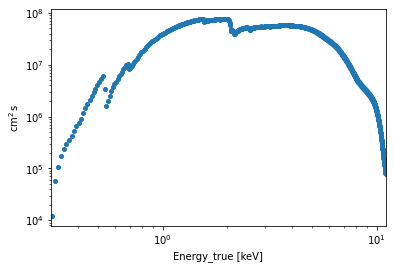

In [7]:
aeff=OGIPDatasetReader.read_arf(arffile,livetime=livetime)
aeff.plot()


In [8]:
map_geom = cube_data.geom.to_image().to_cube(axes=[aeff.geom.axes['energy_true']])
exposure = Map.from_geom(map_geom)
exposure.data += aeff.data.flatten()[:,None, None]
exposure.unit = u.cm**2 *u.s

exposure.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy_true:', layout=Layou…

## mkacisrmf cannot provide rmf binned in Energy reco
Issue mentionned in BUG section of mkacisrmf :  
https://cxc.harvard.edu/ciao/ahelp/mkacisrmf.html

Should maybe interpolate in gammapy.



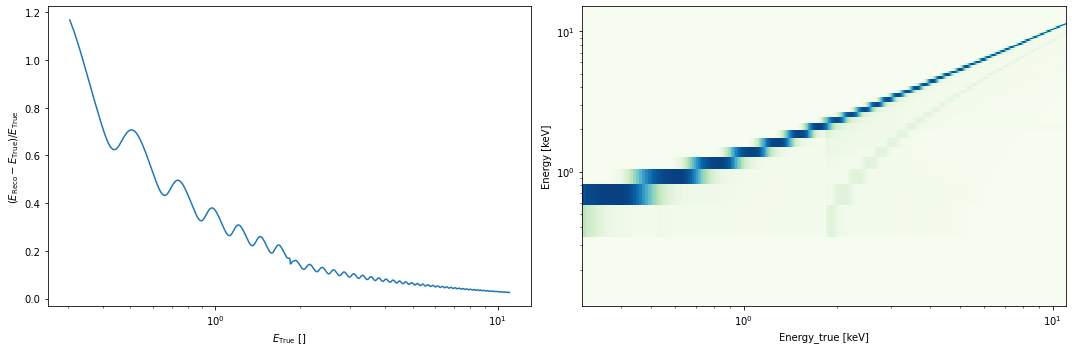

In [9]:
rmffile='data/SNR-circle-ERrebin16-ET10eV.rmf'
rmf=EDispKernel.read(rmffile)
rmf.peek()


Using SUM to rebin


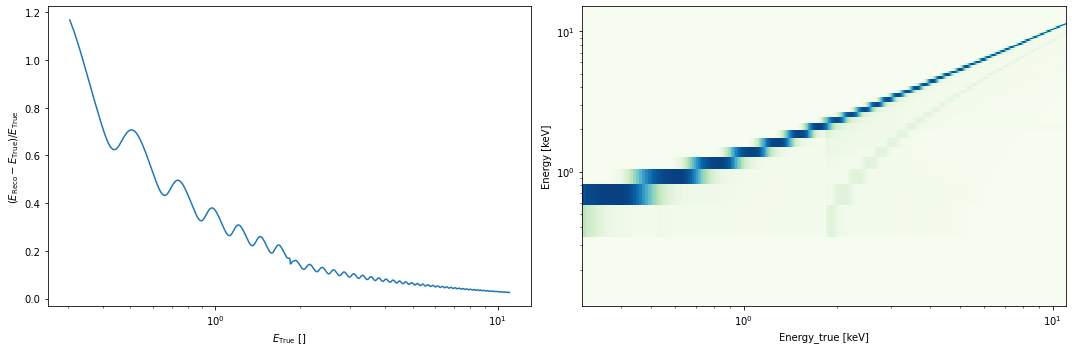

In [10]:
#Loading the standard mkacisrmf RMF (std binning)
#Trying to rebin RMF in gammapy
rmf=EDispKernel.read(rmffile)
rmf.peek()

rmf_=rebin_array(rmf.data,1,16)
rmf.axes['energy'].downsample(16)

# Is there a way to reshape the rmf and replace the values ?

edisp=EDispKernelMap.from_edisp_kernel(rmf, geom=None)




Other alternative is to just load a Gaussian RMF. Should be ok for fitting PL.

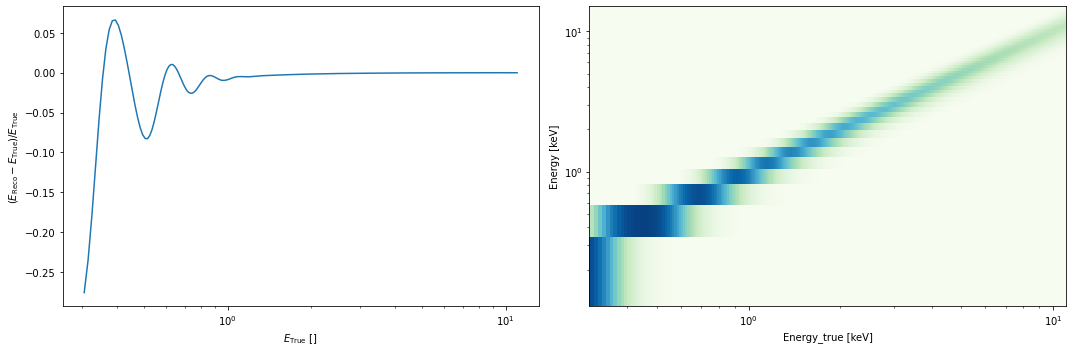

In [11]:
rmf2=EDispKernel.from_gauss(energy_axis_true=aeff.geom.axes['energy_true'],
                            energy_axis=cube_data.geom.axes['energy'],
                            bias=0,
                            sigma=0.1)
rmf2.peek()
edisp2=EDispKernelMap.from_edisp_kernel(rmf2, geom=None)



In [12]:
print('cube_data',cube_data.geom.axes['energy'])


print('edisp',edisp2.edisp_map.geom.axes['energy'])
print('edisp',edisp2.edisp_map.geom.axes['energy_true'])


print('exposure',exposure.geom.axes['energy_true'])

cube_data MapAxis

	name       : energy    
	unit       : 'keV'     
	nbins      : 64        
	node type  : edges     
	edges min  : 1.1e-01 keV
	edges max  : 1.5e+01 keV
	interp     : log       

edisp MapAxis

	name       : energy    
	unit       : 'keV'     
	nbins      : 64        
	node type  : edges     
	edges min  : 1.1e-01 keV
	edges max  : 1.5e+01 keV
	interp     : log       

edisp MapAxis

	name       : energy_true
	unit       : 'keV'     
	nbins      : 1070      
	node type  : edges     
	edges min  : 3.0e-01 keV
	edges max  : 1.1e+01 keV
	interp     : log       

exposure MapAxis

	name       : energy_true
	unit       : 'keV'     
	nbins      : 1070      
	node type  : edges     
	edges min  : 3.0e-01 keV
	edges max  : 1.1e+01 keV
	interp     : log       



Models

Component 0: SkyModel

  Name                      : shell
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : ShellSpatialModel
  Temporal model type       : 
  Parameters:
    NH                      : 23000000000000002097152.000  +/-    0.00 1 / cm2     
    index                   :      2.300   +/-    0.00             
    amplitude               :   4.00e-04   +/- 0.0e+00 1 / (cm2 keV s)
    reference    (frozen)   :      2.000       keV         
    lon_0        (frozen)   :    210.189       deg         
    lat_0        (frozen)   :    -63.429       deg         
    radius                  :     70.000   +/-    0.00 arcsec      
    width        (frozen)   :      5.000       arcsec      

Component 1: SkyModel

  Name                      : pwn
  Datasets names            : None
  Spectral model type       : CompoundSpectralModel
  Spatial  model type       : TemplateSpatialModel
  Temporal model type     

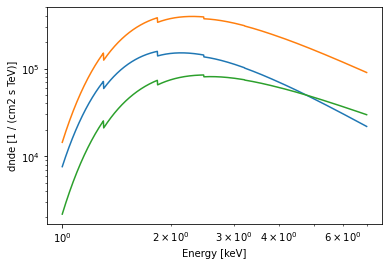

In [13]:
# Define sky model to simulate the data

wabs=WAbsSpectralModel(NH="2.3e22 cm-2") #Value from Reynolds 2019


#PWN model
image=Map.read('data/Cube_IGRJ1400_46pix_XYrebin8_Erebin16_comp0.fits',map_type='wcs')
image.data[image.data<30] = 0

spatial_model = TemplateSpatialModel(image)
spectral_model = wabs*PowerLawSpectralModel(index=1.9, amplitude="1e-3 cm-2 s-1 keV-1", reference="1 keV")
pwn = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model,name='pwn')

pwn.parameters["index"].min = 1
pwn.parameters["index"].max = 5
pwn.parameters['reference'].value = 2

# Shell model
spatial_model = ShellSpatialModel(lon_0=210.1891*u.deg,lat_0= -63.4287*u.deg,radius=70*u.arcsec,width=5*u.arcsec,frame='icrs')
spectral_model = wabs*PowerLawSpectralModel(index=2.3, amplitude="4.e-4 cm-2 s-1 keV-1", reference="1 keV")
shell = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model,name='shell')

shell.parameters['reference'].value = 2
shell.parameters['lon_0'].frozen = True
shell.parameters['lat_0'].frozen = True
shell.parameters['radius'].frozen = False
shell.parameters['width'].frozen = True

shell.parameters['radius'].min = 65
shell.parameters['radius'].max = 75
shell.parameters['width'].min = 1
shell.parameters['width'].max = 10



#shell.parameters["NH"].frozen = True

#shell.spectral_model.NH =  pwn.spectral_model.NH
#shell.spectral_model.parameters['NH']=pwn.spectral_model.parameters['NH']

# PSR model
spatial_model = GaussianSpatialModel(lon_0=210.1905*u.deg, lat_0=-63.4283*u.deg,sigma=0.5*u.arcsec,frame='icrs')
spectral_model = wabs*PowerLawSpectralModel(index=1.5, amplitude="2.e-4 cm-2 s-1 keV-1", reference="1 keV")
psr = SkyModel(spatial_model=spatial_model, spectral_model=spectral_model,name='psr')

psr.parameters['reference'].value = 2
psr.parameters['lon_0'].frozen = True
psr.parameters['lat_0'].frozen = True
psr.parameters['sigma'].frozen = True



sky_model =  (shell + pwn + psr)
print(sky_model)


for n in sky_model.names:
    sky_model[n].spectral_model.plot(energy_bounds=[1, 7] * u.keV, n_points=1000)

In [14]:
mask = Map.from_geom(cube_data.geom)
mask.data = False 
E1, E2 = 1*u.keV, 7*u.keV
i1,i2 =cube_data.geom.axes[0].coord_to_idx([E1,E2])
mask.data[i1:i2,:,:] = True

mask.plot_interactive(add_cbar=True)


interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [15]:
dataset = MapDataset(
    models=sky_model,
    counts=cube_data,
    exposure=exposure,
    edisp=edisp2,
    psf=None,
    mask_fit=mask
)


In [16]:
%time
print((dataset.npred().data*mask).sum(), (cube_data.data*mask).sum() )
#This seems too fast, probably Npred is cached somewhere.

CPU times: user 2 µs, sys: 3 µs, total: 5 µs
Wall time: 1.91 µs
108233.92755836388 139355.0


In [17]:
%time
dataset.reset_data_cache
dataset.npred().data.sum()

CPU times: user 1 µs, sys: 0 ns, total: 1 µs
Wall time: 2.15 µs


110687.1555080796

In [18]:
npred=dataset.npred()
npred.plot_interactive(add_cbar=True)


interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

In [19]:
cube_data.plot_interactive(add_cbar=True)

interactive(children=(SelectionSlider(continuous_update=False, description='Select energy:', layout=Layout(wid…

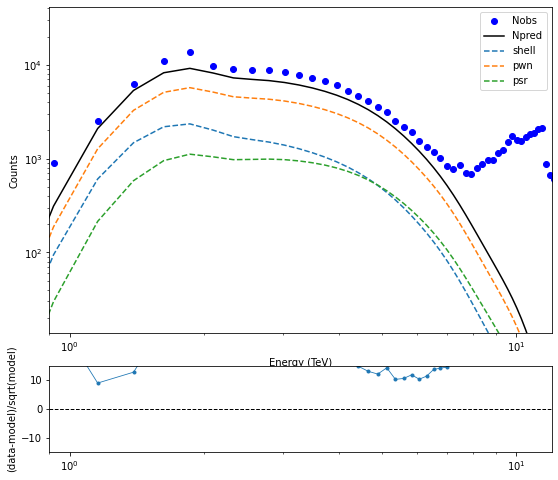

In [20]:
#%%time 
# Plot 1st guess
def plot_data_model(dataset,comp=True):
    npred=dataset.npred()
    e=npred.geom.axes[0].center
    spec_npred=npred.data.sum(axis=(1,2))
    spec_obs=dataset.counts.data.sum(axis=(1,2))

    
    spec_resid=(spec_obs-spec_npred)/np.sqrt(spec_npred)


    fig, ax1 = plt.subplots(1, 1, figsize=(9,6))   

    L=0.125
    #ax1=fig.add_axes((L,0.5,0.775,.4))
    ax1.loglog(e,spec_obs,color='blue',label='Nobs',marker='o',ls='None')
    ax1.loglog(e,spec_npred,color='black',label='Npred')
    if comp:
        for i,mod in enumerate(dataset.models):
            
            dataset_ = MapDataset(
                models=mod,
                counts=dataset.counts,
                exposure=dataset.exposure,
                edisp=dataset.edisp,
                mask_safe=mask)

            npred_comp = dataset_.npred()
            spec_npred_comp = npred_comp.data.sum(axis=(1,2))
            ax1.loglog(e,spec_npred_comp,ls='--',label=mod.name)        
    ax1.set_xlabel('Energy (TeV)')
    ax1.set_ylabel('Counts')
    ax1.set_ylim(spec_obs.max()*1e-3, spec_obs.max()*3)
    ax1.set_xlim(0.9,12)
    plt.legend()


    ax2=fig.add_axes((L,-.15,0.775,.2))


    ax2.plot(e,spec_resid,
                 marker='.',lw=0.8,label='residuals')

    ax2.set_xscale('log')    
    ax2.axhline(0, color='k', lw=1, ls='--')
    ax2.set_ylabel('(data-model)/sqrt(model)')
    ax2.set_xlim(0.9,12)
    ax2.set_ylim(-15,15)


        
plot_data_model(dataset, comp=True)    

In [ ]:
%%time
fit = Fit(optimize_opts={"print_level": 2})
result = fit.optimize(datasets=[dataset])

I MnSeedGenerator Initial state: FCN =        148352.901 Edm =       13522.64291 NCalls =     37
I VariableMetricBuilder Start iterating until Edm is < 0.0002 with call limit = 1320
I VariableMetricBuilder    0 - FCN =        148352.901 Edm =       13522.64291 NCalls =     37
I VariableMetricBuilder    1 - FCN =       140403.9083 Edm =        404.008058 NCalls =     61
I VariableMetricBuilder    2 - FCN =       140070.8516 Edm =       132.1066847 NCalls =     79
I VariableMetricBuilder    3 - FCN =       139810.1715 Edm =       37.15153927 NCalls =     97
I VariableMetricBuilder    4 - FCN =       139786.4469 Edm =       6.803126747 NCalls =    115
I VariableMetricBuilder    5 - FCN =       139741.2952 Edm =       9.707684146 NCalls =    134
I VariableMetricBuilder    6 - FCN =       139708.2905 Edm =       17.21195782 NCalls =    153
I VariableMetricBuilder    7 - FCN =       139654.5335 Edm =       3.369205444 NCalls =    172
I VariableMetricBuilder    8 - FCN =       139650.6104 Edm

In [ ]:
#Know issue about covariance matrix size 
#Fixed in PR https://github.com/gammapy/gammapy/pull/3687

from gammapy.modeling import Covariance
# set covariance independently 
sky_model.covariance = Covariance.from_factor_matrix(
    parameters=sky_model.parameters,
    matrix=fit.minuit.covariance
)

In [ ]:
print(dataset.models)

In [ ]:
plot_data_model(dataset, comp=True)    

## Looking at the residual map

In [ ]:
dataset.residuals(method="diff").sum_over_axes().smooth(width=1).plot(add_cbar=True)

## Residuals around 50, not so bad compared to thousands counts in original data

In [ ]:
(cube_data*mask).sum_over_axes().smooth(width=1).plot(add_cbar=True,stretch='log')